In [30]:
# Install necessary packages
# !pip install gdown
#!pip install gensim==3.8.3

In [8]:
#!pip install lda

In [9]:
# Restart RUNTIME after installing packages!

In [64]:
import pandas as pd
import numpy as np
import gdown
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
import statsmodels.api as sm
import pickle

In [2]:
import sys
sys.path.append('../pymodules')

In [4]:
# define paths and seed
SEED = 92
data_path = "./"

In [5]:
# define dictionary with paths to data in Google Drive
data_url_dict = {"10K_vocab_2019_min25": ("https://drive.google.com/uc?id=1va-ob3C7UD0pYV4Z6WEhL2WMP7ynQJCH", "csv"),
                "10K_dtmatrix_2019_min25": ("https://drive.google.com/uc?id=1c-lNSgaj3tKjnkpn_12ddCL3OP6IsXLT", "txt"),
                "10K_raw_text_2019_min25": ("https://drive.google.com/uc?id=1T97btZK10417MNXGlx_ASFY0mzqpNtu9", "csv"),
                "tic_cik_crosswalk": ("https://drive.google.com/uc?id=1YsbeWapKf_hvfP3qMo9-Xj-PFuH5R96o", "csv"),
                "compustat": ("https://drive.google.com/uc?id=1M87hyFjG74DZy7LoGxc_eHjUgbZEtFif", "csv"),
                "X_tfidf": ("https://drive.google.com/uc?id=1uYYDcL_1P9dB6HKqm726DZ3q02V21XA_", "npy"),
                "X_tfidf_w2v_sg": ("https://drive.google.com/uc?id=1jqmSngcW6JA4ESyrjvQk9lheNspLZ6Sl", "npy"),
                "X_tfidf_glove": ("https://drive.google.com/uc?id=14FO6USCeRLrJ1_Nfjgs23a3BBgSj_lZw", "npy"),
                "X_NMF": ("https://drive.google.com/uc?id=1sROI2YFlGQU9CjHlUGek6zMwDLZxVDJv", "npy"),
                "X_LSA": ("https://drive.google.com/uc?id=12tEYC8D1YdEMHh_U3UC3J9YlbUreqiRg", "npy"),
                "X_lda": ("https://drive.google.com/uc?id=11AB4gSjmPD8z069TsczTYbEZ7t5pXHy-", "npy"),
                "X_d2v": ("https://drive.google.com/uc?id=1inbsTzUlXo56zSR-LZdvodIWGZaDiNv0", "npy"),
                "X_countvec": ("https://drive.google.com/uc?id=1M0O2GqEjPubQc906xRrG3NrF3ow2tN3X", "npy"),
                "X_avgw2v": ("https://drive.google.com/uc?id=1Tz1JTccsWcOxW5HMwtfZ0Ii7JKMOe3-o", "npy"),
                "X_avglove": ("https://drive.google.com/uc?id=1lv9qSazyLMpwyKAb-rXTknF4K0MSnMqr", "npy"),
                "X_avglove_pretrained": ("https://drive.google.com/uc?id=1daFs4bRcchxk0Q54w4mcGUYh49VpmyHb", "npy"),
                "matches_dict": ("https://drive.google.com/uc?id=1Th3aZBqbVAlTS7warTDuStrORD36Rvqw", "sav"),
                }

In [180]:
# download each file in the dictionary (it takes a while)
for file_name, attributes in data_url_dict.items():
    url = attributes[0]
    extension = attributes[1]
    gdown.download(url, f"{file_name}.{extension}", quiet=False) 

Downloading...
From: https://drive.google.com/uc?id=1M87hyFjG74DZy7LoGxc_eHjUgbZEtFif
To: /Users/llaurabat/Dropbox/BGSE_work/AR/ARE_text_algorithms_economics/notebooks/compustat.csv
100%|██████████| 3.78M/3.78M [00:00<00:00, 22.5MB/s]
Downloading...
From: https://drive.google.com/uc?id=1uYYDcL_1P9dB6HKqm726DZ3q02V21XA_
To: /Users/llaurabat/Dropbox/BGSE_work/AR/ARE_text_algorithms_economics/notebooks/X_tfidf.npy
100%|██████████| 619M/619M [00:32<00:00, 19.3MB/s] 
Downloading...
From: https://drive.google.com/uc?id=1jqmSngcW6JA4ESyrjvQk9lheNspLZ6Sl
To: /Users/llaurabat/Dropbox/BGSE_work/AR/ARE_text_algorithms_economics/notebooks/X_tfidf_w2v_sg.npy
100%|██████████| 11.3M/11.3M [00:00<00:00, 24.9MB/s]
Downloading...
From: https://drive.google.com/uc?id=14FO6USCeRLrJ1_Nfjgs23a3BBgSj_lZw
To: /Users/llaurabat/Dropbox/BGSE_work/AR/ARE_text_algorithms_economics/notebooks/X_tfidf_glove.npy
100%|██████████| 22.6M/22.6M [00:00<00:00, 28.5MB/s]
Downloading...
From: https://drive.google.com/uc?id=1s

In [158]:
# run to have plots in LaTeX format

params = {
            'font.family': 'serif',
          'text.usetex': True,
          'axes.titlesize': 15,
          'axes.labelsize': 15,
          'xtick.labelsize': 15,
          'ytick.labelsize': 15,
          'font.weight': 'bold'}
plt.rcParams.update(params)

# Load data

## Load 10K

This tutorial uses text data from the **10-K reports** filed by most publicly-traded firms in the U.S. in 2019. 10-K reports are a very rich source of data since firms include information regarding their organizational structure, financial performance and risk factors. We will use a version of the data where the risk factors section of each report has been splitted into sentences and each sentence has been assigned an ID that combines the firm identifier (i.e. **CIK**) and a sentence number. The data we use has a total of 1,077,416 sentences for 2,500 firms.

More on the 10-K reports [here](https://www.investor.gov/introduction-investing/getting-started/researching-investments/how-read-10-k).

In [25]:
raw_data = pd.read_csv(data_path + '10K_raw_text_2019_min25.csv', index_col='Unnamed: 0')

In [26]:
dt_mat = pd.read_csv(data_path + '10K_dtmatrix_2019_min25.txt', index_col='Unnamed: 0')
dt_vals = dt_mat.values

In [27]:
dt_mat.shape

(4033, 19170)

In [28]:
vocab_df = pd.read_csv(data_path + '10K_vocab_2019_min25.csv', index_col='Unnamed: 0', keep_default_na=False)

In [29]:
vocab = vocab_df.to_dict()['0']

In [30]:
tics = pd.read_csv(data_path+'tic_cik_crosswalk.csv') #3196
raw_data.cik.isin(tics.cik).sum()

3196

In [31]:
# alternative ticker datasets (even fewer matches)

# tickers = pd.read_csv('../../cik_ticker.csv', sep='|') #2684
# tickers2 = pd.read_csv('../../ticker_2.txt', sep='\t', header=None, names=['ticker', 'cik']) #3183

In [32]:
df = raw_data.merge(tics, on='cik', how='left').copy()

## Load compustat

In [181]:
compustat = pd.read_csv(data_path + 'compustat.csv') #36026

In [9]:
comp2019 = compustat[compustat.fyear==2019].copy()
comp2019 = comp2019[comp2019.indfmt=='INDL'].reset_index(drop=True).copy()
cols = ['act', 'at', 'emp', 'cik', 'naics']

In [10]:
comp2019 = comp2019[cols].copy() #3027
print(f'Shape of comp2019: {comp2019.shape}')
print('NAs per column')
display(comp2019.isna().sum())

Shape of comp2019: (3027, 5)
NAs per column


act      623
at         8
emp       84
cik        0
naics      0
dtype: int64

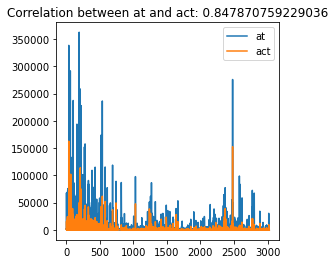

In [11]:
fig, ax = plt.subplots( figsize=(4,4))

plt.title(f"Correlation between at and act: {np.corrcoef( comp2019.dropna()['at'],comp2019.dropna()['act'])[0,1]}")

plt.plot(comp2019.dropna()['at'], label='at')
plt.plot(comp2019.dropna().act, label='act')
plt.legend()

plt.show()

In [12]:
# drop act
cols = [ 'at', 'emp', 'cik', 'naics']
comp2019 = comp2019[cols].copy()

In [13]:
# rescale
comp2019['at'] = 1000*comp2019['at']
comp2019['emp'] = 1000*comp2019['emp']

In [14]:
print('N. observations above 10 by column')
print(f"{comp2019[(comp2019['at']>10)].shape[0]} for at")
print(f"{comp2019[(comp2019['emp']>10)].shape[0]} for emp")

N. observations above 10 by column
3012 for at
2695 for emp


In [15]:
comp2019 = comp2019[(comp2019.emp>10)& (comp2019['at']>10)].copy() 

In [16]:
comp2019 = comp2019.dropna().copy() #2695
print(f'Shape of df after cleaning: {comp2019.shape}')

Shape of df after cleaning: (2695, 4)


In [40]:
comp2019['naics2'] = comp2019.naics.apply(lambda x: int(str(x)[:2]))

## Load similarities

In [182]:
#%%
X_countvec = np.load(data_path + 'X_countvec.npy')
X_tfidf = np.load(data_path + 'X_tfidf.npy')
X_LSA = np.load(data_path + 'X_LSA.npy')
X_NMF = np.load(data_path + 'X_NMF.npy')
X_lda = np.load(data_path + 'X_lda.npy')
X_d2v = np.load(data_path + 'X_d2v.npy')
X_tfidf_w2v_sg = np.load(data_path + 'X_tfidf_w2v_sg.npy')
X_avgw2v = np.load(data_path + 'X_avgw2v.npy')
X_tfidf_glove = np.load(data_path + 'X_tfidf_glove.npy')
X_avglove = np.load(data_path + 'X_avglove.npy')
X_avglove_pretrained = np.load(data_path + 'X_avglove_pretrained.npy')

In [43]:
####### COSINE SIMILARITIES
# %%
sims_countvec = cosine_similarity(X_countvec)
sims_tfidf = cosine_similarity(X_tfidf)
sims_lsa = cosine_similarity(X_LSA)
sims_nmf = cosine_similarity(X_NMF)
sims_lda = cosine_similarity(X_lda)
sims_d2v = cosine_similarity(X_d2v)
sims_tfidf_w2v_sg = cosine_similarity(X_tfidf_w2v_sg)
sims_avgw2v = cosine_similarity(X_avgw2v)
sims_tfidf_glove = cosine_similarity(X_tfidf_glove)
sims_avglove = cosine_similarity(X_avglove)
sims_avglove_pretrained = cosine_similarity(X_avglove_pretrained)
#%%

# Pair similarity of cik i to cik j with correspondent covariates

In [44]:
ciks_vocab = raw_data.to_dict()['cik']
ciks_vocab = {v:k for k,v in ciks_vocab.items()}

In [183]:
# %%time
# 18 min

# matches = {'idx_pair':[], 'cik_pair':[],
# 'naics':[], 'naics2':[], 'emp':[], 'at':[], 'sims_countvec':[], 'sims_tfidf':[], 'sims_lsa':[], 'sims_nmf':[],
# 'sims_lda':[], 'sims_d2v':[], 'sims_tfidf_w2v_sg':[], 'sims_avgw2v':[], 'sims_tfidf_glove':[], 'sims_avglove':[],
#            'sims_avglove_pretrained':[]}
# for i in range(comp2019.shape[0]):
#     for j in range(i+1, comp2019.shape[0]):

#         row_i = comp2019.iloc[i].copy()
#         row_j = comp2019.iloc[j].copy()

#         cik_i = row_i.cik
#         cik_j = row_j.cik
#         matches['cik_pair'].append((cik_i,cik_j))

#         idx_i = ciks_vocab[cik_i]
#         idx_j = ciks_vocab[cik_j]
#         matches['idx_pair'].append((idx_i,idx_j))
#         matches['sims_countvec'].append(sims_countvec[idx_i, idx_j])
#         matches['sims_tfidf'].append(sims_tfidf[idx_i, idx_j])
#         matches['sims_lsa'].append(sims_lsa[idx_i, idx_j])
#         matches['sims_nmf'].append(sims_nmf[idx_i, idx_j])
#         matches['sims_lda'].append(sims_lda[idx_i, idx_j])
#         matches['sims_d2v'].append(sims_d2v[idx_i, idx_j])
        
#         matches['sims_tfidf_w2v_sg'].append(sims_tfidf_w2v_sg[idx_i, idx_j])
#         matches['sims_avgw2v'].append(sims_avgw2v[idx_i, idx_j])
#         matches['sims_tfidf_glove'].append(sims_tfidf_glove[idx_i, idx_j])
#         matches['sims_avglove'].append(sims_avglove[idx_i, idx_j])
#         matches['sims_avglove_pretrained'].append(sims_avglove_pretrained[idx_i, idx_j])
        

#         naics_i = row_i.naics
#         naics_j = row_j.naics
#         matches['naics'].append(1 if naics_i==naics_j else 0)
        
#         naics2_i = row_i.naics2
#         naics2_j = row_j.naics2
#         matches['naics2'].append(1 if naics2_i==naics2_j else 0)

#         for cov in ['at', 'emp']:
#             cov_i = row_i[cov]
#             cov_j = row_j[cov]
#             cov_val = np.log(cov_i/cov_j)
#             matches[cov].append(cov_val)
#     if i%200==0:
#         print(i)

In [52]:
# filename = data_path + 'matches_dict.sav'
# with open(filename, 'wb') as f:
#     pickle.dump((matches), f)

In [53]:
filename = data_path + 'matches_dict.sav'
with open(filename, 'rb') as fr:
    matches = pickle.load(fr)

# Regression analysis

In [56]:
df_all = pd.DataFrame.from_dict(matches)

In [57]:
print('n. observations:', df_all.shape)

n. observations: (3630165, 17)


In [171]:
SEED=879

In [172]:
sample =df_all.sample(10000, random_state=SEED)

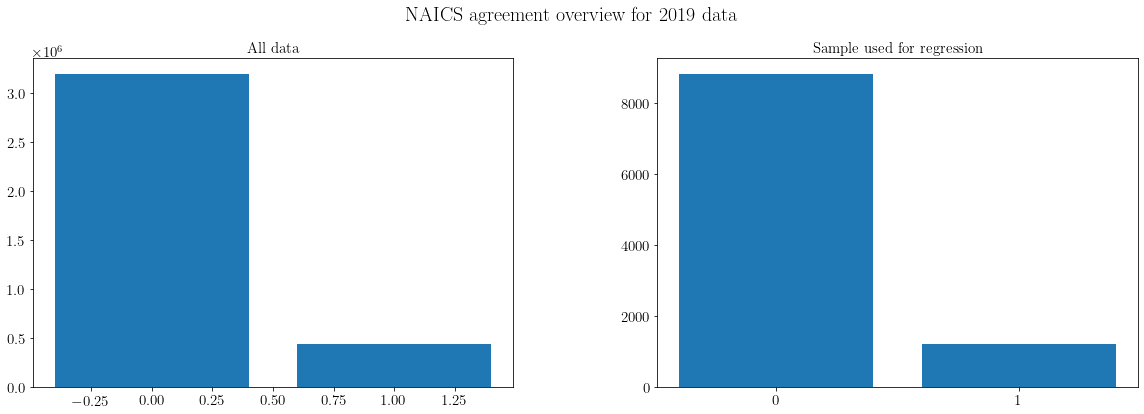

In [173]:
fig, ax = plt.subplots(1,2, figsize=(16,6))

fig.suptitle(f"NAICS agreement overview for 2019 data", fontsize=20)

ax[0].bar([0,1], df_all.naics2.value_counts())
ax[0].set_title('All data')

ax[1].bar([0,1], sample.naics2.value_counts())
ax[1].set_title('Sample used for regression')


plt.tight_layout()
plt.subplots_adjust(left=None, bottom=0.1, right=None, top=0.86, wspace=0.3, hspace=0.3)
plt.xticks([0,1])

plt.show()

In [174]:
ys_labs = ['sims_countvec', 'sims_tfidf', 'sims_lsa', 'sims_nmf',
'sims_lda', 'sims_d2v', 'sims_tfidf_w2v_sg', 'sims_avgw2v', 
           'sims_tfidf_glove', 'sims_avglove','sims_avglove_pretrained']

cov_labs = ['naics2', 'at', 'emp']
X = sample[cov_labs].copy()
X_c = sm.add_constant(X)

In [175]:
# scale X
X_c['at'] = X_c['at']/(X_c['at'].std())
X_c['emp'] = X_c['emp']/(X_c['emp'].std())

In [176]:
res_by_model ={y_lab:{'params':[], 'conf_int':[]} for y_lab in ys_labs}
for y_lab in ys_labs:
    # scale y
    y = sample[y_lab]/(sample[y_lab].std())
    
    model = sm.OLS(y, X_c)
    results = model.fit()
    res_by_model[y_lab]['params'].append(results.params.values)
    res_by_model[y_lab]['conf_int'].append(results.conf_int().values)

In [177]:
res_by_covariate ={cov:{'params':{}, 'conf_int':{}} for cov in (['intercept'] + cov_labs)}

for y_lab in ys_labs:
    res_by_covariate['intercept']['params'][y_lab] = res_by_model[y_lab]['params'][0][0]
    res_by_covariate['intercept']['conf_int'][y_lab] = res_by_model[y_lab]['conf_int'][0][0]

    res_by_covariate['naics2']['params'][y_lab] = res_by_model[y_lab]['params'][0][1]
    res_by_covariate['naics2']['conf_int'][y_lab] = res_by_model[y_lab]['conf_int'][0][1]

    res_by_covariate['at']['params'][y_lab] = res_by_model[y_lab]['params'][0][2]
    res_by_covariate['at']['conf_int'][y_lab] = res_by_model[y_lab]['conf_int'][0][2]

    res_by_covariate['emp']['params'][y_lab] = res_by_model[y_lab]['params'][0][3]
    res_by_covariate['emp']['conf_int'][y_lab] = res_by_model[y_lab]['conf_int'][0][3]

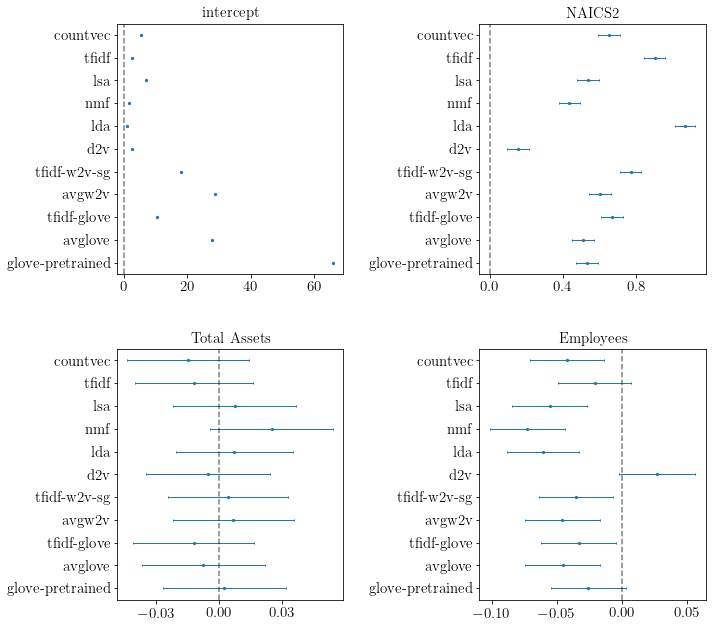

In [184]:
fig, ax = plt.subplots(2,2, figsize=(10,10))

# fig.suptitle('Regression of cik similarity on compustat covariates \n with intercept',
# size=20)

names = ['countvec', 'tfidf', 'lsa', 'nmf',
'lda', 'd2v', 'tfidf-w2v-sg', 'avgw2v', 'tfidf-glove', 'avglove','glove-pretrained']
cov_labs = list(res_by_covariate.keys())
cov_lab_names = ['Intercept', 'NAICS2', 'Total Assets', 'Employees']

for ix,a in enumerate(ax.flatten()):
    reg_mean = np.array(list(res_by_covariate[cov_labs[ix]]['params'].values()))
    CI = np.array(list(res_by_covariate[cov_labs[ix]]['conf_int'].values()))
    err = (CI - reg_mean[:,None])
    err = np.abs(err)

    a.scatter(reg_mean[::-1], range(len(names)), s=5, color='#1f77b4')
    a.set_title(cov_lab_names[ix])
    for x, y, er in zip(reg_mean[::-1],range(len(names)),  err[::-1]):
        a.errorbar(x=x, y=y, xerr=er[:,None], fmt='none', 
        elinewidth=1, capsize=1, color='#1f77b4')
    a.set_yticks(range(len(ys_labs)))
    a.set_yticklabels(names[::-1])
    a.axvline(0, linestyle='dashed', color='black', alpha=0.5)
#     a.set_ylim(top=1.1)
    a.xaxis.set_major_locator(plt.MaxNLocator(4))

plt.tight_layout()
plt.subplots_adjust(left=None, bottom=0.1, right=None, top=0.9, wspace=0.6, hspace=0.3)
plt.savefig('reg_cosine_similarity_compustat_10000pairs.png')

plt.show()